$$
\begin{aligned}
\underset{\Large{\text{Mohit Gupta, Spring 2018}}}{\large{\text{Computer Vision CS 766}}} \\
\end{aligned}
$$

$$
\begin{aligned}
\underset{\large{\text{Due date: Monday May 7, 2018}}}{\Large{\text{Object Detection & Image Mosaicing for Video Content Summarization}}} \\
\end{aligned}
$$

$$
\begin{aligned}
\underset{\large{\text{abhanshu@cs.wisc.edu}}}{\large{\text{Abhanshu Gupta}}} && \underset{\large{\text{varun@cs.wisc.edu}}}{\large{\text{Varun Sah}}} \\
\end{aligned}
$$

## <center>1. Introduction and Motivation</center> ##
With the advent of smart phones with high-quality cameras, video and image content is being generated at an unprecedented rate, rendering the task of manual content identification and classification virtually impossible. Content identification and classification tasks impact human lives in many ways. Content categorization enables delivery of personalized content based on user preferences. At the same time, it is instrumental in maximizing revenue for several industries. For instance, the advertising and marketing industry is a particularly visual world, with millions of images and videos displayed everyday within websites, television programs, and movies, in order to expose consumers to the latest trends and products. 

The sheer volume of media existing today motivates the need for automated software systems that leverage state-of-the-art artificial intelligence (AI) and computer vision (CV) techniques for accomplishing the content cataloging task efficiently. AI and CV based software allow for visual product discovery and categorization, thereby reducing the reliance on manually entered, subjective, noisy product meta-data. Their ability to group similar products based on their visual affinity makes the process of categorization objective, noise-free and exponentially faster as compared to methods that require human intervention. However, like many other computer vision problems, a single approach that is universally considered the obvious or “best” method to address the problem of content categorization efficiently and effectively is lacking. 

Another problem closely associated with video and image categorization is that of content summarization. There is a growing need for automatically generating aesthetically pleasing visualizations that are representative of categorized content and provide the viewer with a preview or overview of the actual content in the media. This project is aimed at efficient and effective summarization of video content by means of real time object detection and image mosaicing.

## <center>2. Problem Statement</center> ##
This project is aimed at enabling automatic content summarization of videos by creating a representative mosaic of the video's object of focus. We intend to do this in a three-step process involving real time object detection, salient object identification and image mosaicing. Each of these steps is described in detail in the forthcoming section.

## <center>3. Methodology</center> ##

Our proposed content summarization pipeline comprises of three modules namely Object detection, Salient Object Identification and Image Mosaicing. 

### 3.1 Object Detection###
Object detection is the problem of finding and classifying a variable number of objects on an image. Object detection has proven to be a hard problem as compared to classification, since its output is variable in dimensions due to the inherent differences in object size and number across images. Object detection in videos is an even more challenging task than object detection in images primarily due to the motion and blur effects that result in detection failures on certain frames.

A traditional method for object detection is using Histogram of Oriented Gradients(HOG) features and Support Vector Machine (SVM) for classification. It requires a multi-scale sliding window making it much slower. In recent years deep learning has been a real game changer in computer vision. Deep learning models have virtually replaced classical techniques for the tasks of image classification and object detection and are currently an active area of research in computer vision. Many deep learning models are already in place that are state of the art in object detection. These models are fast and provide high accuracy and detection efficiency. In this phase, we leveraged state-of-the-art frameworks like R-CNN, R-FCN, YOLO and SSD for application-specific object detection. 
 
### 3.2 Salient Object Identification###
After obtaining the output of the object detection module, we extracted information about the content and salient objects of the video based on a mixture of heuristics and learned decisions.  In this phase, we determined the content of the video by analyzing identified object categories, their frequency of occurrence and the mutual relationship between objects detected in the video. The output of this module was a list of tags or categories associated with identified objects along with their frames of occurrence in the video as well as the object of interest (the salient object).


### 3.3 Image Mosaicing###
Mosaicing is an old art technique where pictures or designs are formed by inlaying small bits of colored stone, glass, or tile. These small bits are visible close up, but the boundaries of the bits will blend and a single recognizable image will show at a distance. In the modern digital world, this ancient art form has been transformed and combined with new technologies. Instead of using pure-colored blocks, entire images can be used as tiles to make an overall pictures.

After obtaining the output of the Object Detection and Salient Object Identification modules, we chose a representative image as our target image. Using other occurrences of the same object (as well as other significant objects), we reconstructed the target image in the form of a mosaic. This aesthetic visualization would be our final output that succinctly provides a visual preview of the video content and an overview of the object of interest.

## <center>4. Results</center> ##

### 4.1 Object Detection ###

In [1]:
%run setup.py build_ext --inplace

In [1]:
import cv2
import os
from darkflow.net.build import TFNet
import numpy as np
import sys
import operator
from operator import itemgetter
from PIL import Image, ImageStat, ImageEnhance
from IPython.display import Image as JImage
import shutil
from shutil import copyfile

In [2]:
PRODUCT = 'car'
INPUT_VIDEO = "Ads/" + PRODUCT + "_ad.mp4"
OUTPUT_DIR = "Jupyter_Results/"+ PRODUCT + "_ad/"

In [3]:
def process_video(video, result_dir):
    #defining network model options for object detection
    option = {
        'model': 'cfg/yolov2.cfg',
        'load': 'bin/yolov2.weights',
        'threshold': 0.5
    }
    # initializing the network
    tfnet = TFNet(option)
    # initializing return parameters
    frequency = {}
    prediction_results = {}
    #initializing colors (used for printing tagged results)
    colors = [tuple(255 * np.random.rand(3)) for i in range(5)]
    
    #creating results directory
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    #define downsampling speed   
    i = 0
    frame_rate_divider = 3
    
    #reading video frames
    capture = cv2.VideoCapture(video)    
    while (capture.isOpened()):
        ret, frame = capture.read()
        if ret:
            if i % frame_rate_divider == 0:
                #predicting objects in the frame
                results = tfnet.return_predict(frame)
                for result in results:
                    #adding bounding box area in result
                    result['area'] = abs((result['topleft']['x'] - result['bottomright']['x'])*(result['topleft']['y'] - result['bottomright']['y']))
                    label = result['label']
                    #writing images in folders based on predicted categories
                    directory = result_dir+"/"+label
                    if not os.path.exists(directory):
                        os.makedirs(directory)
                    file_name = directory+"/"+"frame_"+str(i)+".jpg"
                    cv2.imwrite(file_name, frame)
                    
                    #calculate frequency of each label and populating the prediction results
                    if label in frequency.keys():
                        frequency[label] += 1 
                        prediction_results[label].append(tuple((i,result)))
                    else:
                        frequency[label] = 1
                        prediction_results[label] = [tuple((i,result))]
                #code to write tagged images in result directory
                j = 0
                taggedDir = result_dir+"/tagged_results/"
                if not os.path.exists(taggedDir):
                        os.makedirs(taggedDir)
                results = sorted(results, key=itemgetter('confidence'), reverse=True)
                for color, result in zip(colors, results):
                    j += 1
                    tl = (result['topleft']['x'], result['topleft']['y'])
                    br = (result['bottomright']['x'], result['bottomright']['y'])
                    label = result['label']
                    frame = cv2.rectangle(frame, tl, br, color, 7)
                    frame = cv2.putText(frame, label, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
                    if j > 5:
                        #print(type(result))
                        #print(type(result['confidence']))
                        j = 0
                        
                    file = taggedDir+"/"+"frame_"+str(i)+".jpg"
                    cv2.imwrite(file, frame)
                i += 1
            else:
                i += 1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            capture.release()
            cv2.destroyAllWindows()
            break
    return frequency, prediction_results

In [4]:
frequency, prediction_results = process_video(INPUT_VIDEO,OUTPUT_DIR)

Parsing ./cfg/yolov2.cfg
Parsing cfg/yolov2.cfg
Loading bin/yolov2.weights ...
Successfully identified 203934260 bytes
Finished in 0.1729581356048584s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76

#### Mercedez Ad ####
- Ad URL: https://www.youtube.com/watch?v=p8XfJtlvHuE
- Samples of Cars identified:/Jupyter_Results/car_ad/car/
- Link to directory containing all identified objects:/Jupyter_Results/car_ad/

#### Phone Ad ####
- Ad URL: https://www.youtube.com/watch?v=4qy2HStwYgE
- Samples of phones identified:/Jupyter_Results/phone_ad/phone/
- Link to directory containing all identified objects:/Jupyter_Results/phone_ad/

#### Laptop Ad ####
- Ad URL: https://www.youtube.com/watch?v=g2_5v-JUr-k
- Samples of laptops identified: /Jupyter_Results/laptop_ad/laptop/
- Link to directory containing all identified objects: /Jupyter_Results/laptop_ad/

#### Tennis Racket Ad ####
- Ad URL: https://www.youtube.com/watch?v=eqJgq1k45xw
- Samples of tennis rackets identified:/Jupyter_Results/racket_ad/tennis racket/
- Link to directory containing all identified objects: /Jupyter_Results/racket_ad/

### 4.2 Salient Object Identification ###

In [5]:
#classes related to living biengs that mostly will not be salient object in ad
heuristic_exceptions = ['person','cat','dog', 'bird', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
def select_salient_object(frequency,top_n):
    #sort on frequency
    sorted_frequency_array = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)
    sorted_frequency_dict = dict(sorted_frequency_array[:top_n])
    print('Object frequencies: \n', sorted_frequency_array)

    #get salient object label
    labels = list(sorted_frequency_dict.keys())
    candidate_labels = list(set(labels) - set(heuristic_exceptions))
    print('Candidate objects: \n', candidate_labels);
    for label, frequency in sorted_frequency_array:
        if label in candidate_labels:
            return label
    return ''

In [6]:
salient_category = select_salient_object(frequency,5)
print('Salient Object Category:', salient_category)

Object frequencies: 
 [('car', 119), ('person', 26), ('scissors', 17), ('truck', 5), ('parking meter', 1), ('chair', 1), ('phone', 1), ('mouse', 1), ('motorbike', 1), ('clock', 1), ('remote', 1)]
Candidate objects: 
 ['parking meter', 'scissors', 'car', 'truck']
Salient Object Category: car


In [7]:
def image_stats(file):
    #load image as grayscale
    img = Image.open(file).convert('L')
    #compute rms brightness
    stat = ImageStat.Stat(img)
    brightness = stat.rms[0]
    #compute sharpness
    array = np.asarray(img, dtype=np.int32)
    gy, gx = np.gradient(array)
    g_norm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(g_norm)
    return brightness, sharpness

In [8]:
BRIGHT_THRES = 50
SHARP_THRES = 2.5
tile_dir = OUTPUT_DIR+salient_category+'/'
brightness_vector = []
sharpness_vector = []

In [9]:
#compute threshold and determine target frame
def select_representative_frame(salient_category, prediction_results):
    category_result = prediction_results[salient_category]
    category_result.sort(key = lambda x: x[1]['area'],reverse = True)
    for entry in category_result:
        frame_num = entry[0]
        path = tile_dir+"frame_"+str(frame_num)+".jpg"
        brightness, sharpness = image_stats(path)
        brightness_vector.append(brightness)
        sharpness_vector.append(sharpness)
    
    BRIGHT_THRES = np.median(np.asarray(brightness_vector))
    SHARP_THRES = np.mean(np.asarray(sharpness_vector)) - np.std(np.asarray(sharpness_vector))
    print(BRIGHT_THRES, SHARP_THRES)
    i = 0
    for entry in category_result: 
        frame_num = entry[0]
        path = tile_dir+"frame_"+str(frame_num)+".jpg"
        if(brightness_vector[i] > BRIGHT_THRES and sharpness_vector[i] > SHARP_THRES):
            print(frame_num, brightness_vector[i], sharpness_vector[i], path)
            return path
        i += 1

In [ ]:
#create results directory
if not os.path.exists('results/'):
    os.makedirs('results/')

73.52218479412211 1.539831141749291 5.250938039656879 0.25991852820248323
282 74.91438106276632 2.8066304327424927 Jupyter_Results/car_ad/car/frame_282.jpg


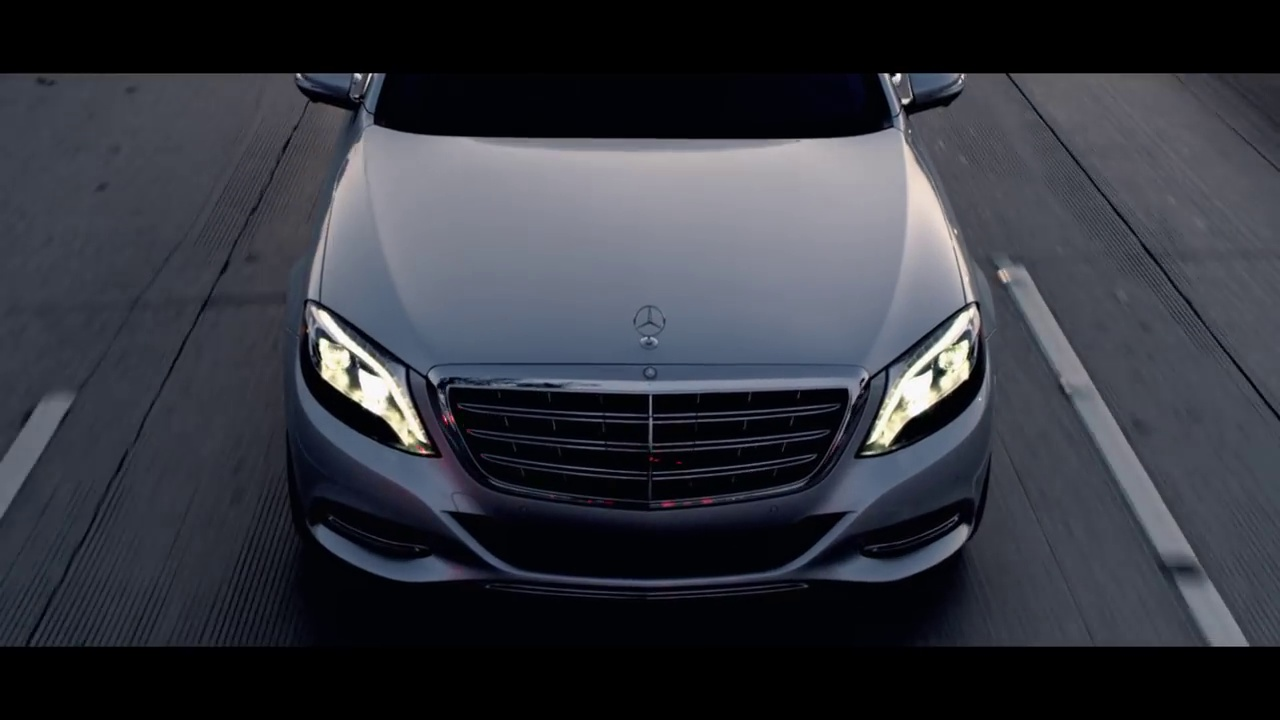

In [10]:
target_img = select_representative_frame(salient_category, prediction_results)
INPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_target.jpg'
shutil.copy2(target_img, INPUT_MOSAIC)
JImage(INPUT_MOSAIC)

### 4.3 Image Mosaicing ###

#### Approach #### 

In [11]:
TILE_SIZE = 100
RESOLUTION = 10
#0-crude mosaic,1-noise removal,2-color enhaced using local reconcilliation,3- color enhanced resolution
OPERATION_MODE = 0
OUTPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_'+str(TILE_SIZE)+'_'+str(RESOLUTION)+'_'+str(OPERATION_MODE)+'.jpg'

In [12]:
#compute distance between colors
def compute_distance(color1, color2):
    assert len(color1) == len(color2)
    dist = 0
    for i in range(0, len(color1)):
        dist += abs(color1[i]-color2[i])
    return dist

#get average color
def compute_avg_color(img):
    if OPERATION_MODE == 0:
        pixels = img.load();
        channels = len(pixels[0, 0])
        colours = [0] * channels
        for x in range(0, img.width):
            for y in range(0, img.height):
                for channel in range(0, channels):
                    colours[channel] += pixels[x, y][channel]

        colours = list(map(lambda x: int(x / (img.width * img.height)), colours))
        return colours
    else :
        return img.resize((1, 1), Image.ANTIALIAS).getpixel((0, 0))

In [13]:
def create_mosaic(target_img,tiles_dir):
    #load and resize tile images
    tiles_images = []
    for name in os.listdir(tiles_dir):
        path = os.path.join(tiles_dir, name)
        tile = Image.open(path)
        tile = tile.resize((TILE_SIZE, TILE_SIZE), Image.ANTIALIAS)
        tiles_images.append({
            "image": tile,
            "color": compute_avg_color(tile)
        })
    #load target image
    target = Image.open(target_img)
    #create output image
    w, h = target.size
    output_dim = (w*RESOLUTION, h*RESOLUTION)
    mosaic = Image.new("RGB", output_dim)
    #get tile matching dimensions
    w_matching = int(output_dim[0]/TILE_SIZE)
    h_matching = int(output_dim[1]/TILE_SIZE)
    #resize target image for matching
    target = target.resize((w_matching, h_matching), Image.ANTIALIAS)
    #find best match for each pixel
    x_out = 0
    y_out = 0
    for y in range(0, h_matching):
        for x in range(0, w_matching):
            min_dist = -1
            best_idx = -1
            idx = 0
            for tile in tiles_images:
                dist = compute_distance(target.getpixel((x, y)), tile["color"])
                if min_dist == -1 or dist < min_dist:
                    min_dist = dist
                    best_idx = idx
                idx += 1
            
            selected_tile = tiles_images[best_idx]['image']
            if OPERATION_MODE == 2:
                ratio = 0
                for i in range(0, 3):
                    ratio += (target.getpixel((x, y))[i]-tile['color'][i])/tile['color'][i]
                ratio = 1+ratio/3
                enhancer = ImageEnhance.Color(selected_tile)
                selected_tile = enhancer.enhance(ratio)
            elif OPERATION_MODE == 3:
                ratio = (w_matching+h_matching)/TILE_SIZE
                enhancer = ImageEnhance.Color(selected_tile)
                selected_tile = enhancer.enhance(ratio)
            #paste selected tile in the mosaic
            mosaic.paste(selected_tile, (x_out, y_out))
            #increment the mosaic position counters
            x_out += TILE_SIZE
            if x_out == output_dim[0]:
                x_out = 0
                y_out += TILE_SIZE
    #save the generated mosaic
    mosaic.save(OUTPUT_MOSAIC)
    

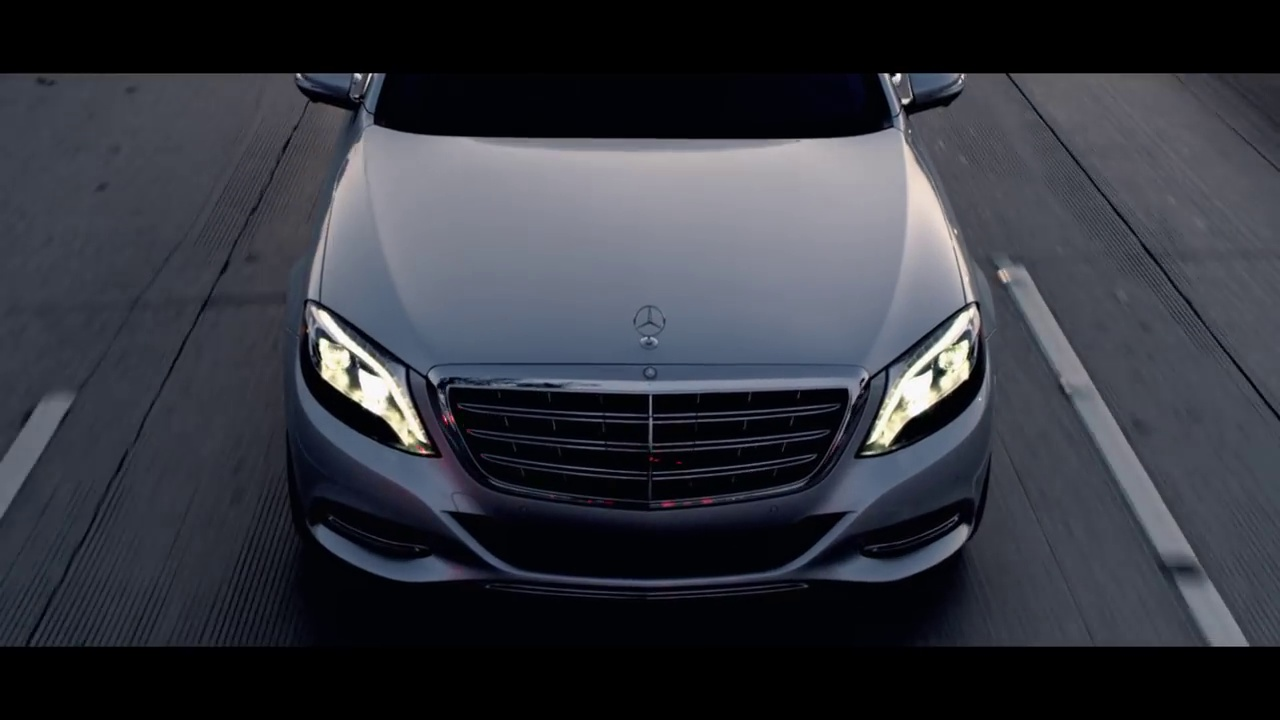

In [14]:
JImage(INPUT_MOSAIC)

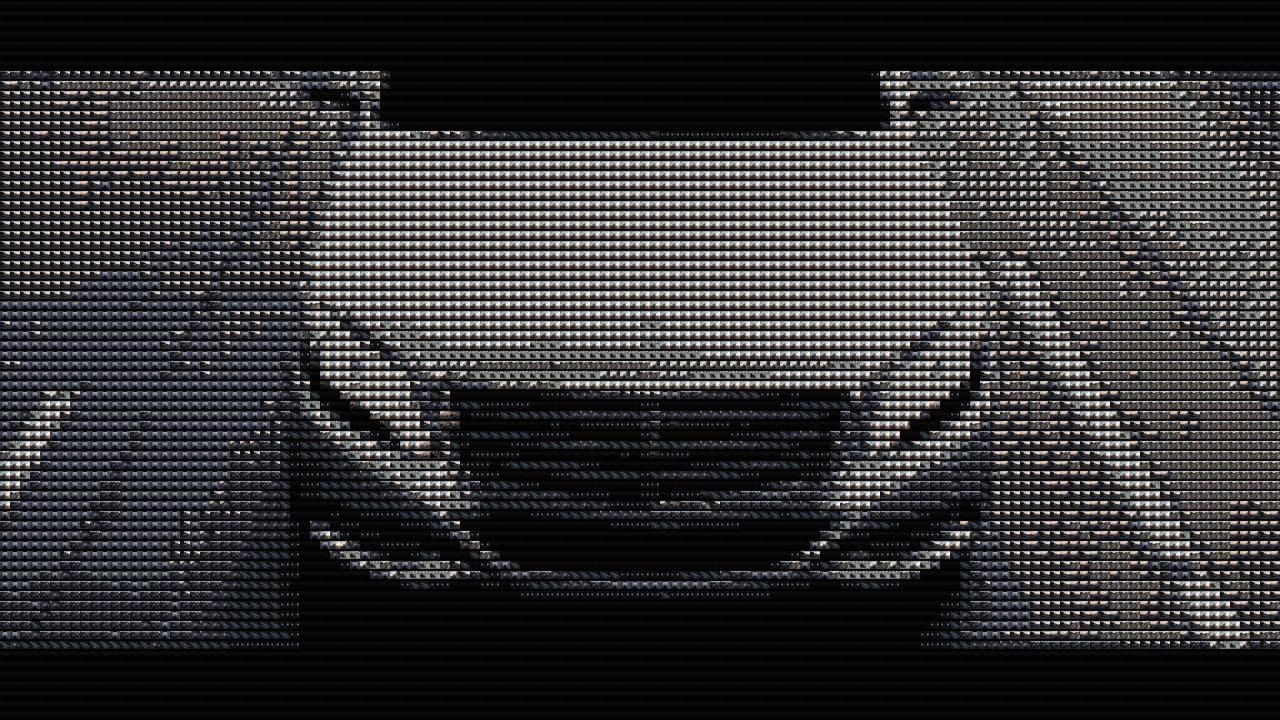

In [15]:
TILE_SIZE = 100
RESOLUTION = 10
OPERATION_MODE = 0 #0,1,2,3
OUTPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_'+str(TILE_SIZE)+'_'+str(RESOLUTION)+'_'+str(OPERATION_MODE)+'.jpg'
create_mosaic(INPUT_MOSAIC, tile_dir)
JImage(OUTPUT_MOSAIC)

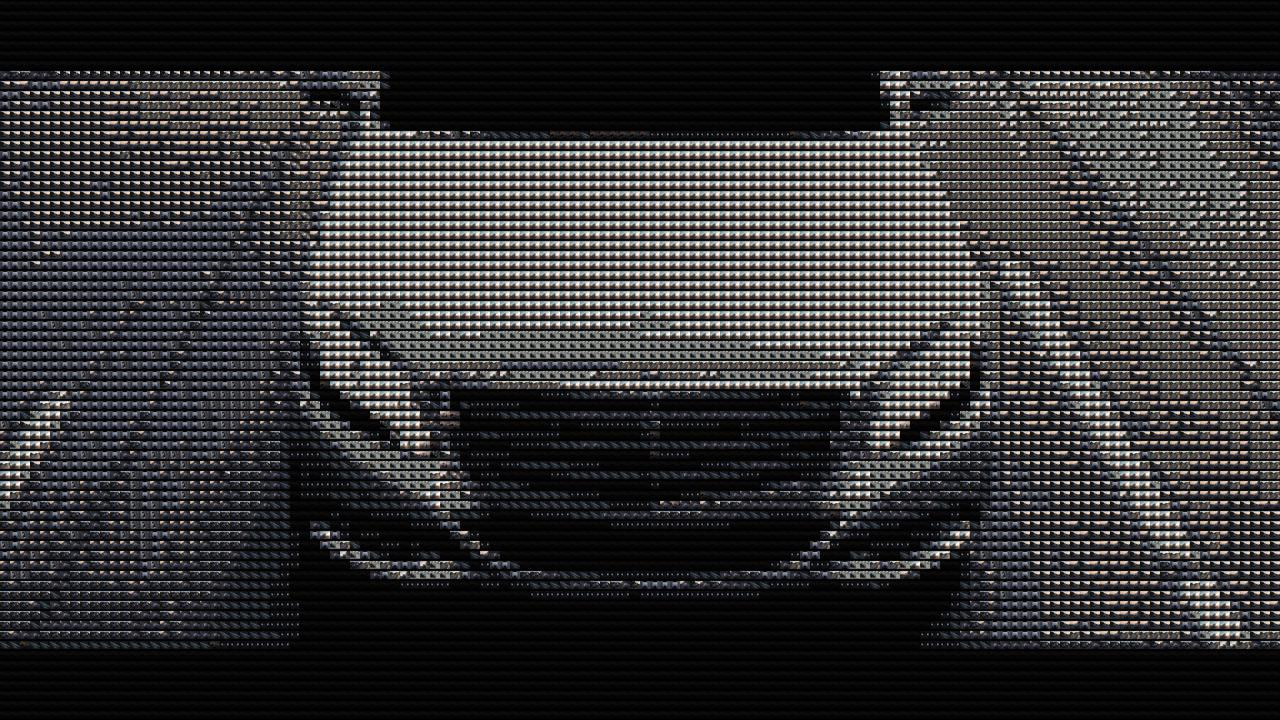

In [16]:
TILE_SIZE = 100
RESOLUTION = 10
OPERATION_MODE = 1 #0,1,2,3
OUTPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_'+str(TILE_SIZE)+'_'+str(RESOLUTION)+'_'+str(OPERATION_MODE)+'.jpg'
create_mosaic(INPUT_MOSAIC, tile_dir)
JImage(OUTPUT_MOSAIC)

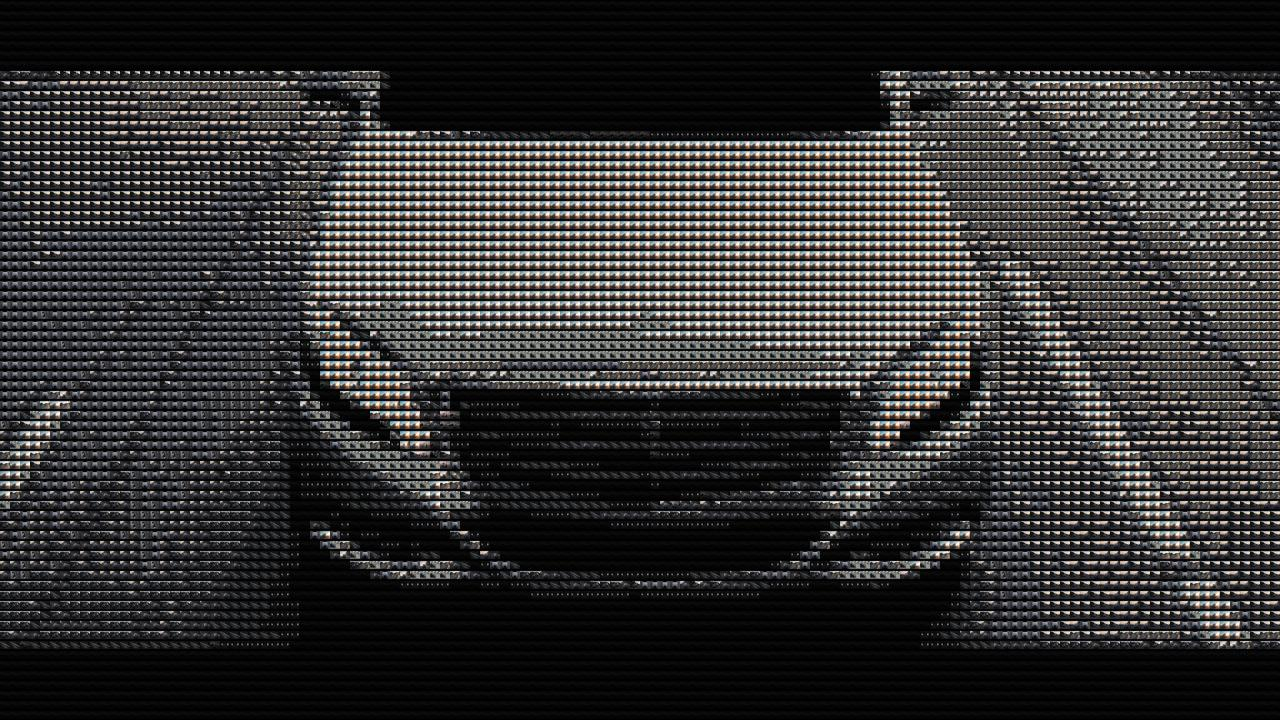

In [17]:
TILE_SIZE = 100
RESOLUTION = 10
OPERATION_MODE = 2 #0,1,2,3
OUTPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_'+str(TILE_SIZE)+'_'+str(RESOLUTION)+'_'+str(OPERATION_MODE)+'.jpg'
create_mosaic(INPUT_MOSAIC, tile_dir)
JImage(OUTPUT_MOSAIC)

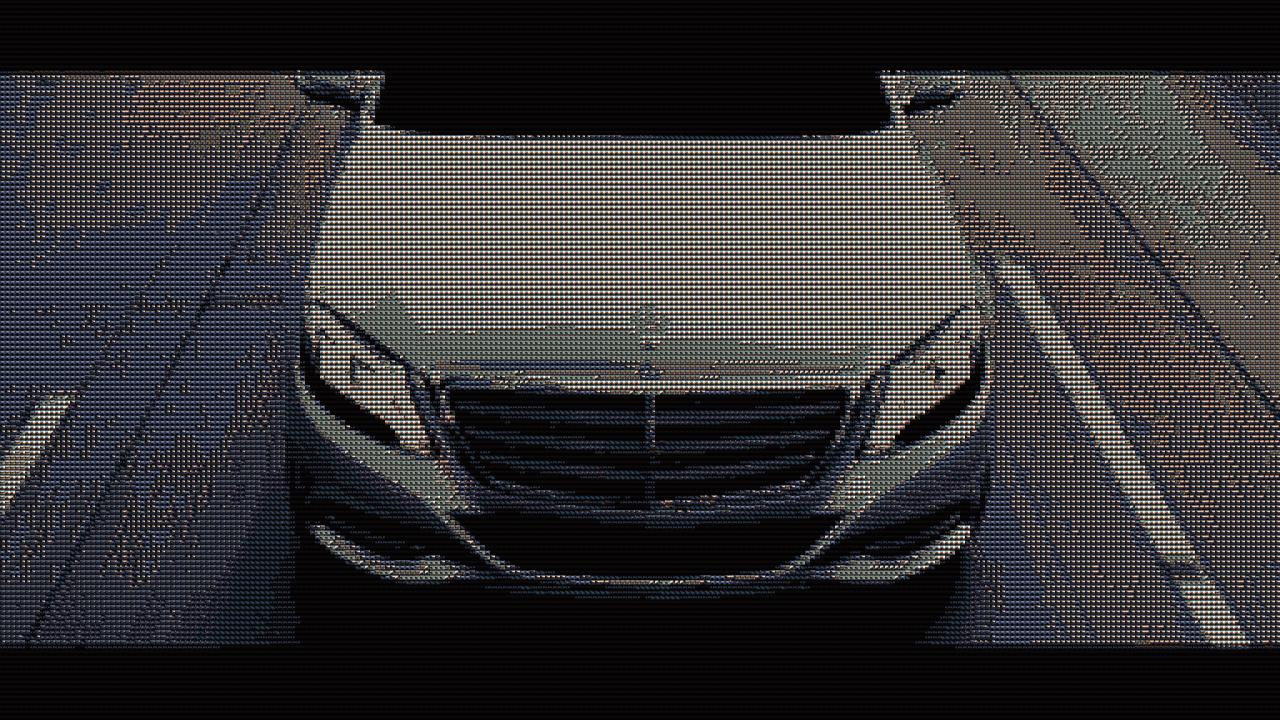

In [19]:
TILE_SIZE = 100
RESOLUTION = 10
OPERATION_MODE = 3 #0,1,2,3
OUTPUT_MOSAIC = 'results/mosaic_'+PRODUCT+'_'+str(TILE_SIZE)+'_'+str(RESOLUTION)+'_'+str(OPERATION_MODE)+'.jpg'
create_mosaic(INPUT_MOSAIC, tile_dir)
JImage(OUTPUT_MOSAIC)

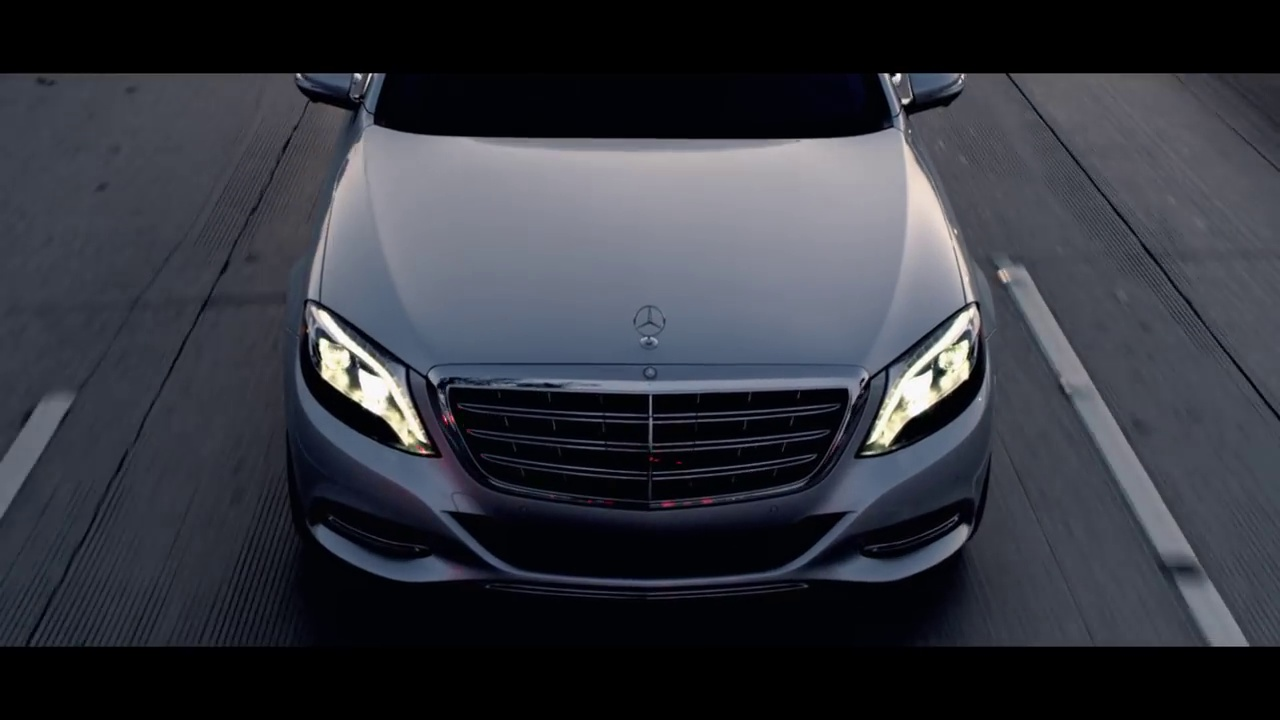

In [39]:
JImage(INPUT_MOSAIC)

 ## <center>5. Discussion</center> ##

The following subsections include a discussion of some of the challenges we faced during the project thus far.

### 5.1 Incorrect object detection ### 
Despite having remarkable accuracy, the object detection module was by no means perfect in its classification of objects. A major cause of these mis-classifications was found to be motion-blur and scene-transition blurring in videos that possessed slow or smooth fade-in/fade-out transitions between different scenes. This transition-blur caused the image to possess artifacts that were a combination of artifacts from separate scenes. Figure \ref{fig:b_iod} illustrates misclassification due to motion-blur and scene-transition blur.

Another classification error was found to be occur in peculiar circumstances wherein a flexible object was found to metamorphose into a shape that represents a different entity. For instance, Figure \ref{fig:s_iod} illustrates misclassification of a human arm (shaped like elephant's ears and trunk) as an elephant, the Mercedes logo mistaken for a clock, and a bag (shaped like a horse's snout) labelled as a horse.

In order to handle each of the aforementioned imperfections in classification, we suppressed objects detected during the salient object identification phase using a composite of frequency and confidence thresholding (described in \ref{soi}). 
Detected objects falling short of these thresholds were no longer considered candidates for being the salient object of focus.

### 5.2 Salient Object Heuristics ###
Since most advertisements feature humans in some capacity or the other, people were often the most frequently detected object in commercials. Heuristically, we decided to disqualify people from being candidates for the object of focus. More generally, this heuristic can be extended to most living creatures who are seldom advertised in commercials. It is worth noting that this strategy is applicable only in the presence of an object that has a significant frequency even if that frequency is lower than that of \textit{person} class. This would ensure that mobile phone commercials, despite featuring more humans than phones, would still be classified correctly, while political campaign advertisements would be accurately identified as being people-centric. 

### 5.3 Limited Computation Power ###
Lack of computational power due to absence of access to GPU-equipped machines was identified to be a common factor that limited our ability to improve certain undesirable outcomes. The classification time for videos currently takes longer than the length of the video, which is undesirable for scalability reasons. This could be avoided if machines with GPUs were accessible to us since the object identification task naturally lends itself to  parallelization. Lack of computing power is also the primary reason for avoiding repeated iterative training or tweaking of network architecture due to the huge training and testing time overheads.